### Here I study how to take completeness and measurement error into account when plotting the mass-size relation.

Poor size, SB, total mag measurement affects:

1. Mass-size relation (related to size, total mag, color)
2. UDG distribution profile (only completeness?)
3. Quenched fraction (color, total mag)

In [4]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack
from astropy.coordinates import SkyCoord

In [7]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

#### Load completeness from Greco's detection and vanilla scarlet

In [11]:
import pickle
from scipy.interpolate import interp2d
from scipy.stats import binned_statistic_2d

In [312]:
x = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness-x.txt')
y = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness-y.txt')
greco_comp_map = np.loadtxt(f'./Catalog/Greco_completeness_S18A/completeness.txt') / 100

# 2d interpolation
f_greco = interp2d(x, y, greco_comp_map)

# Load vanilla scarlet completeness
with open('./Catalog/completeness/completeness_vanilla_scarlet.pkl', 'rb') as f:
    (deblend_map, _extent, _x_edge, _y_edge) = pickle.load(f)
_range = [_extent[:2], _extent[2:]]

# Coarse grid
detection_map = f_greco((_x_edge[1:] + _x_edge[:-1])
                       / 2, (_y_edge[1:]
                       + _y_edge[:-1]) / 2)

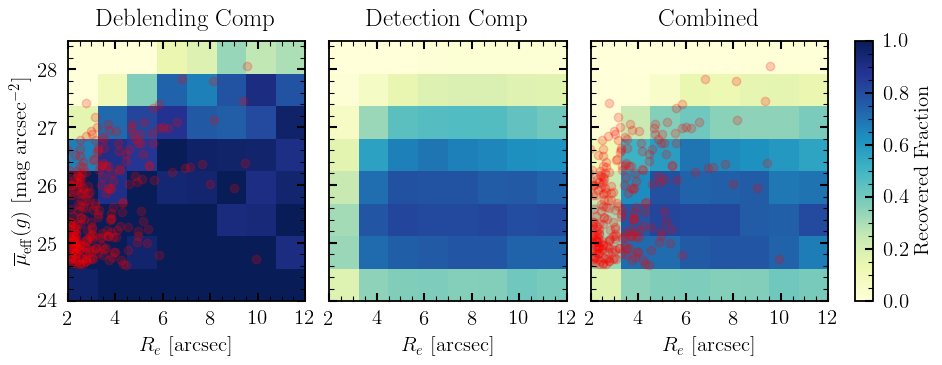

In [313]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.6), sharey=True, sharex=False)

# Deblend + Modeling completeness
plt.sca(axes[0])
im = plt.imshow(deblend_map, 
                extent=_extent, 
                vmin=0, vmax=1, 
                aspect='auto',
                cmap='YlGnBu')
plt.scatter(R_e, SB_g, color='r', alpha=0.2)

# Greco's detection completeness
plt.sca(axes[1])
plt.imshow(
    detection_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )

# Together
plt.sca(axes[2])
plt.imshow(
    detection_map * deblend_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    cmap='YlGnBu',
    )
plt.scatter(R_e, SB_g, color='r', alpha=0.2)


for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')

axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[0].set_title('Deblending Comp')
axes[1].set_title('Detection Comp')
axes[2].set_title('Combined')


fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.1, hspace=0.3)

### A summary distribution of UDGs

In [369]:
udg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z002_004/udg_z002_004_spergel_after_viz.fits')

In [370]:
# SB and R_e
SB_g_meas = udg_cat['SB_eff_avg'][:, 0].data
R_e = udg_cat['rhalf_spergel'].data * 0.168

# Correct for the measurement error
with open('./Catalog/completeness/Re_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
R_e += f_med(SB_g_meas)
R_e_std = f_std(SB_g_meas)

ang_diam_dist = udg_cat['host_ang_diam_dist'].data # not consider peculiar motion
R_e_phys = R_e / 206265 * ang_diam_dist * 1000 # in kpc
R_e_phys_std = R_e_std / 206265 * ang_diam_dist * 1000 # in kpc

with open('./Catalog/completeness/SB_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)

SB_g = SB_g_meas + f_med(SB_g_meas)
SB_g_std = f_std(SB_g_meas)

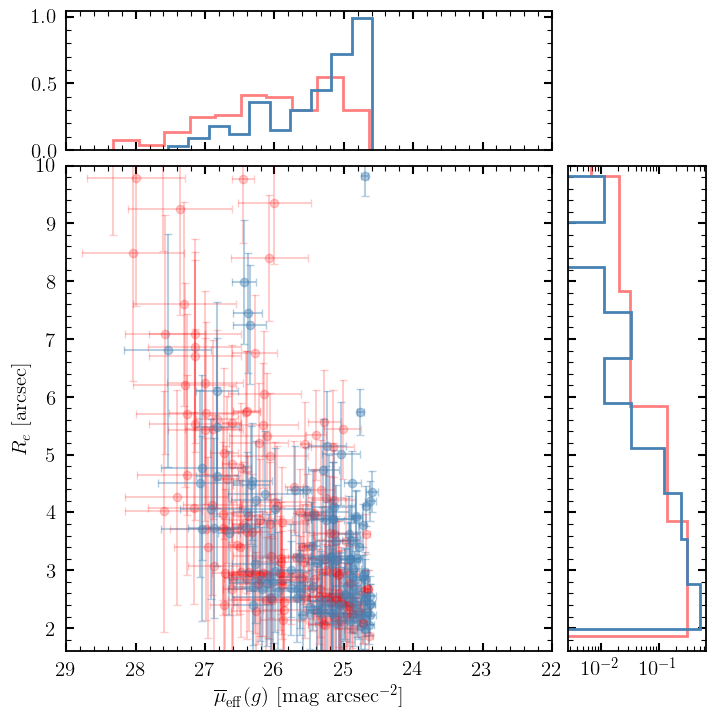

In [371]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]) > 0.8)

ax.errorbar(SB_g[red], 
            R_e[red], 
            xerr=SB_g_std[red], yerr=R_e_std[red],
            fmt='o', color='r', alpha=0.2)

ax.errorbar(SB_g[~red], 
            R_e[~red], 
            xerr=SB_g_std[~red], yerr=R_e_std[~red],
            fmt='o', color='steelblue', alpha=0.4)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(SB_g[red], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(SB_g[~red], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(R_e[red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(R_e[~red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

### Get completeness weight for each UDG

In [372]:
f_comp = interp2d((_x_edge[1:] + _x_edge[:-1]) / 2, 
                   (_y_edge[1:] + _y_edge[:-1]) / 2, 
                   detection_map, kind='cubic')
comp = np.array([f_comp(*p)[0] for p in zip(R_e, SB_g)])

### Size distribution (after taken measurement error and completeness into account)

In [576]:
n_bins = 10
range_0 = np.array([np.log10(1.5), np.log10(12)])
edges_0 = np.histogram_bin_edges(np.log10(R_e_phys), bins=n_bins,
                                 range=range_0)

_ns = []
for i in range(100):
    _R_e_phys = R_e_phys + np.random.normal(loc=0, scale=R_e_phys_std)
    # account for measurement error, we re-generate new R_e w.r.t R_e_std
    _ns.append(np.histogram(
        np.log10(_R_e_phys), 
        bins=n_bins,
        range=range_0, 
        weights=1/comp)[0])
_ns = np.array(_ns)

Text(0, 0.5, '$n\\ [\\rm dex^{-1}]$')

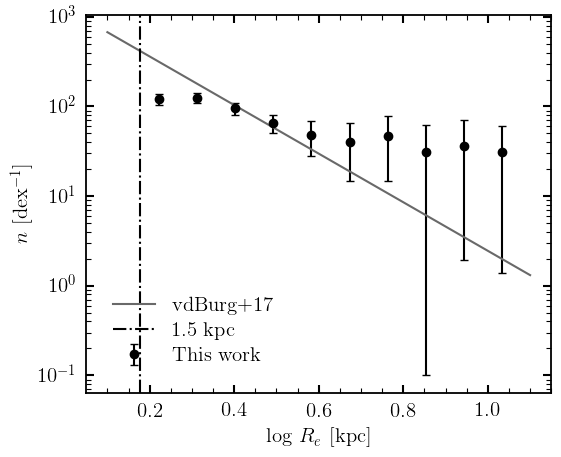

In [577]:
n_cen = np.nanmean(_ns, axis=0)
n_std = np.nanstd(_ns, axis=0)

bin_cen = (edges_0[:-1] + edges_0[1:]) / 2
plt.errorbar(bin_cen, n_cen, yerr=n_std, fmt='ok', 
             markersize=6, label='This work')

    
x = np.linspace(0.1, 1.1)
plt.plot(x, 10**(-2.71 * x + 3.1), color='dimgray', label='vdBurg+17')

plt.axvline(np.log10(1.5), ls='-.', color='k', label='1.5 kpc')
# plt.text(np.log10(1.6), 0.1, '1.5 kpc', color='gray')
plt.legend()

plt.yscale('log')
plt.xlabel(r'$\log\,R_e\ [\rm kpc]$')
plt.ylabel(r'$n\ [\rm dex^{-1}]$')

## Mass-size relation

1. Mass problem with M/L? (Into & Portinari (2013), as described further in Carlsten et al. (2021b).)
We take the solar absolute magnitude in g to be 5.03 for g-filter (Willmer 2018, although there's not data for HSC filters).

$$
\begin{aligned}
&\log \left(M_{\star} / L_{g}\right)=1.774(g-r)-0.783 \\
&\log \left(M_{\star} / L_{g}\right)=1.297(g-i)-0.855
\end{aligned}
$$

In [473]:
ang_diam_dist = udg_cat['host_ang_diam_dist'].data
udg_cat['abs_mag'] = udg_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # griz

### Absolute magnitude ###
g_mag = udg_cat['mag'][:, 0].data
g_abs = udg_cat['abs_mag'][:, 0].data
# Correct for measurement error
with open('./Catalog/completeness/mag_g_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
g_abs += f_med(g_mag)
g_abs_std = f_std(g_mag)

### Color
gr_color = (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]).data
with open('./Catalog/completeness/gr_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
gr_color += f_med(gr_color)
gr_color_std = f_std(gr_color)

gi_color = (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]).data
with open('./Catalog/completeness/gi_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
gi_color += f_med(gi_color)
gi_color_std = f_std(gi_color)

# average over g-i and g-r results
log_ML_g = np.array([1.297 * gi_color - 0.855, 
                     1.774 * gr_color - 0.783]).mean(axis=0)

log_ML_g_std = np.sqrt((1.297 * gi_color_std)**2 + (1.774 * gr_color_std)**2) / 2

M_g = -0.4 * (g_abs - 5.03) + log_ML_g
M_g_std = np.sqrt((0.4 * g_abs_std)**2 + log_ML_g_std**2)

# udg_cat['log_m_star'] = M_g
# udg_cat['g_abs'] = g_abs

(6.8, 9.2)

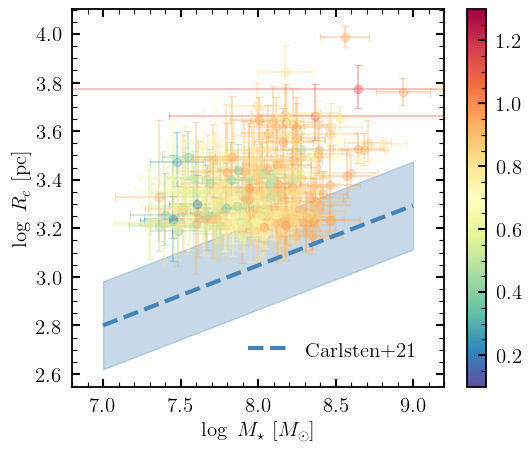

In [476]:
import matplotlib
from matplotlib.colors import Normalize

norm = Normalize(vmin=0.1, vmax=1.3)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(gi_color)

yerrs = np.array([np.log10(R_e_phys + R_e_phys_std) - np.log10(R_e_phys), 
         np.log10(R_e_phys) - np.log10(R_e_phys - R_e_phys_std)])

for i,_ in enumerate(M_g):
    sct = plt.errorbar(
        M_g[i], 
        np.log10(R_e_phys[i]) + 3, # in pc
        xerr=M_g_std[i],
        yerr=yerrs[:, i].reshape(-1, 1),
        color=_colors[i],
        fmt='o', alpha=0.35)
plt.colorbar(sm)

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

plt.xlim(6.8, 9.2)

### Quenched fraction figure: meas error, completeness, etc.

In [550]:
# distance to host
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord).to(u.deg).value
dist_vir = dist / udg_cat['host_r_vir_ang'].data

Quenched fraction as a function of UDG stellar mass

In [557]:
red = (gi_color > 0.8)
identity = np.ones_like(red)

n_bins = 8

edges = np.histogram_bin_edges(M_g, bins=n_bins, range=(7, 9))
quench_frac = []
dist2host = []
for i in range(1, n_bins+1):
    flag = np.digitize(M_g, edges) == i
    r = np.average(red.astype(float)[flag], weights=(1/comp)[flag]) if np.sum(flag) > 0 else np.nan
    quench_frac.append(r)
    
    r = np.average(dist_vir[flag], weights=(1 / comp)[flag]) if np.sum(flag) > 0 else np.nan
    dist2host.append(r)
    
quench_frac = np.array(quench_frac)
dist2host = np.array(dist2host)
    
num, _, _ = binned_statistic(M_g, 1 / comp, statistic='sum', range=(7, 9), bins=n_bins)

_cen = (edges[:-1] + edges[1:]) / 2

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

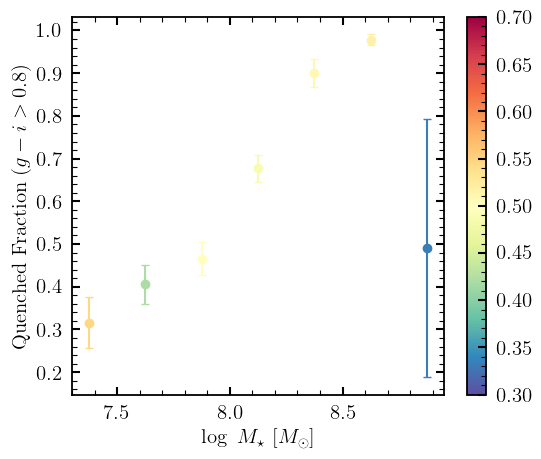

In [558]:
norm = Normalize(vmin=0.3, vmax=0.7)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(dist2host)

for i in range(len(quench_frac)):
    plt.errorbar(_cen[i], 
                 quench_frac[i], 
                 yerr=np.sqrt(quench_frac * (1 - quench_frac) / num)[i], 
                 color=_colors[i],
                 fmt='o')

plt.colorbar(sm)

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

Quenched fraction as a function of **host** stellar mass

In [559]:
red = (gi_color > 0.8)
identity = np.ones_like(red)

n_bins = 8

edges = np.histogram_bin_edges(M_g, bins=n_bins, range=(10.2, 11.2))
quench_frac = []
dist2host = []
for i in range(1, n_bins+1):
    flag = np.digitize(udg_cat['host_stellar_mass'], edges) == i
    r = np.average(red.astype(float)[flag], weights=(1/comp)[flag]) if np.sum(flag) > 0 else np.nan
    quench_frac.append(r)
    
    r = np.average(dist_vir[flag], weights=(1 / comp)[flag]) if np.sum(flag) > 0 else np.nan
    dist2host.append(r)
    
quench_frac = np.array(quench_frac)
dist2host = np.array(dist2host)
    
num, _, _ = binned_statistic(udg_cat['host_stellar_mass'], 1 / comp, 
                             statistic='sum', 
                             range=(10.2, 11.2), bins=n_bins)

_cen = (edges[:-1] + edges[1:]) / 2

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

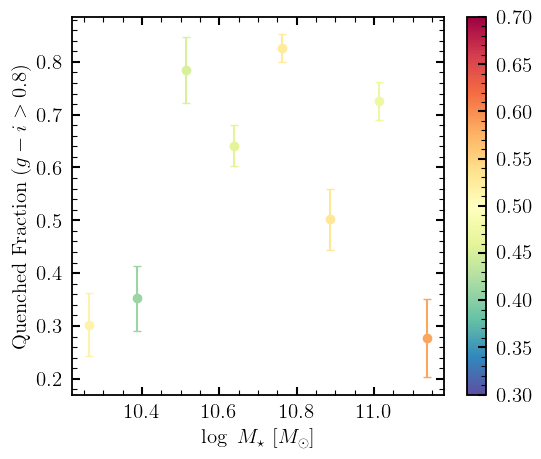

In [560]:
norm = Normalize(vmin=0.3, vmax=0.7)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(dist2host)

for i in range(len(quench_frac)):
    plt.errorbar(_cen[i], 
                 quench_frac[i], 
                 yerr=np.sqrt(quench_frac * (1 - quench_frac) / num)[i], 
                 color=_colors[i],
                 fmt='o')

plt.colorbar(sm)

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

projected radius
red near contamination

---

In [561]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

In [562]:
flag = (yagi_cat['Re1'].data.data > 1.5)# & (yagi_cat['SuBr0'].data.data > 24.5)
yagi_cat = yagi_cat[flag]

In [563]:
yagi_cat['log_m_star'] = (4.83 - yagi_cat['Rmag1'] + 35.05) / (2.5)

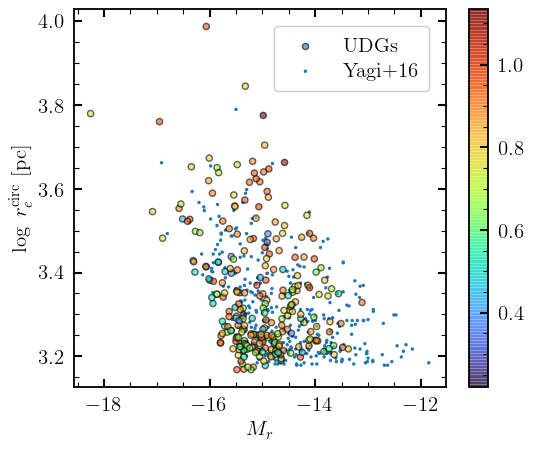

In [575]:
sct = plt.scatter(udg_cat['abs_mag'][:, 1], 
            np.log10(R_e_phys) + 3, 
            c=gi_color, s=20,
                  alpha=0.6, edgecolors='k',
            label='UDGs')
plt.colorbar()

#x = np.linspace(7, 9)
# plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
#                  mass_size_carlsten(x) + 0.181, 
#                  color='steelblue', alpha=0.3)
# plt.plot(x, mass_size_carlsten(x), ls='--', 
#          color='steelblue', lw=3, label='Carlsten+21')


plt.scatter(yagi_cat['Rmag1'] - 35.05, np.log10(yagi_cat['Re1']) + 3, 
            label='Yagi+16', edgecolor='none', s=6, zorder=0)

plt.xlabel(r'$M_r$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(frameon=True)